In [401]:
import numpy as np
import scipy as sp
import sklearn as skl
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from skimage.transform import resize
import matplotlib as mpl
import matplotlib.pyplot as plt
import zipfile as zf
import pandas as pd
# import cv2
import PIL as pil

In [2]:
archive = zf.ZipFile('data/archive.zip')

metafile  = archive.open('Meta.csv')
testfile  = archive.open('Test.csv')
trainfile = archive.open('Train.csv')

meta  = pd.read_csv(metafile)
test  = pd.read_csv(testfile)
train = pd.read_csv(trainfile)

train_images = [ mpl.image.imread(archive.open(imfile)) for imfile in train.Path]
train_labels = np.array(train.ClassId)

test_images = [ mpl.image.imread(archive.open(imfile)) for imfile in test.Path]
test_labels = np.array(test.ClassId)

In [338]:
def get_img_ndims(img):
    # Check if image is 3D. If 2D, assume grayscale. 
    # Also, if last dimension is not of length 3, assume image is 
    # grayscale and any additional leading dimensions describe
    # array of images and should be preserved.
    input_dims = np.ndim(img)
    if input_dims < 3 or img.shape[-1] != 3:
        img_dims = 2
    else: 
        img_dims = 3
        
    return img_dims


def adjust_range(img):
    ''' Handle the fact that some pixel values are outside [0,1] range.'''
    img_dims = get_img_ndims(img)
    pixel_axes = tuple(np.arange(np.ndim(img)-img_dims,np.ndim(img)))
    rescaled_img  = img/np.ptp(img,axis=pixel_axes)
    rescaled_img -= np.min(rescaled_img,axis=pixel_axes)
    
    return rescaled_img


def flatten(img, rgb2gray=False):
    # Convert image to grayscale first
    if rgb2gray:
        img = np.mean(img,axis=-1)
        
    img = np.ravel(img)
    
    return img


def process(img, resize_to=None, flat=True, rgb2gray=False):
    # Resize image to desired size
    if resize_to is not None:
        img = resize(img, crop_to) 
        
    # Rescale image to have all pixel values on [0,1]
    img = adjust_range(img)
    
    if flat:
        img = flatten(img, rgb2gray=rgb2gray)
    return img


shapes = np.array([im.shape for im in train_images])
resize_to = np.min(shapes,axis=0)

train_data = np.array([process(img, resize_to=resize_to, flat=True) for img in train_images])
test_data  = np.array([process(img, resize_to=resize_to, flat=True) for img in test_images]) 

In [308]:
pca = skl.decomposition.PCA()
pca_train = pca.fit_transform(train_data)

In [343]:
dtree = DecisionTreeClassifier()

dtree.fit(pca_train, train_labels)


pca_test = pca.transform(test_data)

# predict labels using the trained classifier
predicted_test_labels = dtree.predict(pca_test)

In [351]:
cm = confusion_matrix(test_labels, predicted_test_labels)

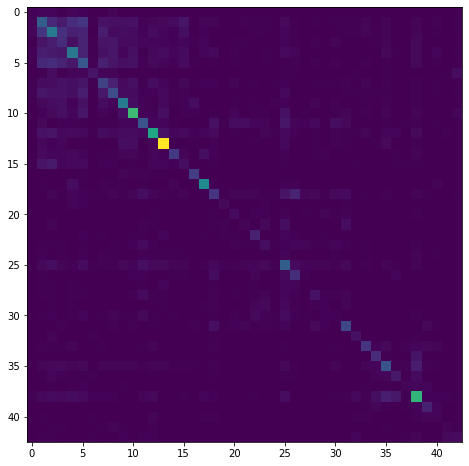

In [356]:
plt.figure(figsize=(8,8))
plt.imshow(cm)

In [409]:
accuracy_score(test_labels, predicted_test_labels) 

0.3728424386381631